<a href="https://colab.research.google.com/github/AlinFin/Tumor/blob/main/brain_tumor_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)



In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
from sklearn.metrics import classification_report

In [55]:
!pip install kaggle

In [7]:
#move the uploaded kaglle jason to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 89% 132M/149M [00:01<00:00, 136MB/s]
100% 149M/149M [00:01<00:00, 132MB/s]


In [ ]:
!unzip brain-tumor-mri-dataset.zip

In [10]:
# Define the path to the test and train datasets
train_dir = 'Training'
test_dir='Testing'

In [12]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [13]:
# Go over the train dataset:
for i in categories:
    path = os.path.join(train_dir, i)
    for img in os.listdir(path):
        img_array_train = cv2.imread(os.path.join(path,img))

# Go over the test dataset:
for i in categories:
    path = os.path.join(test_dir, i)
    for img in os.listdir(path):
        img_array_test = cv2.imread(os.path.join(path,img))

In [14]:
#This is size of each image - 512x512 with 3 channels (RGB)
print(img_array_train.shape)
print(img_array_test.shape)

(512, 512, 3)
(512, 512, 3)


In [15]:
#Count the number of files in each directory

# Get a list of all files and folders in the directory
files_and_folders = os.listdir(train_dir) # ['glioma', 'meningioma', 'notumor', 'pituitary']
files_and_folders1 = os.listdir(test_dir)


# Count the number of pictures in each folder
train_categories = []
train_counts = []
for folder in files_and_folders:
    folder_path = os.path.join(train_dir, folder)
    num_pictures = len(os.listdir(folder_path))
    train_categories.append(folder)
    train_counts.append(num_pictures)
    print(f"Number of pictures in train folder {folder}: {num_pictures}")


# Count the number of pictures in each folder for testing dataset
test_categories = []
test_counts = []
for folder in files_and_folders1:
    folder_path = os.path.join(test_dir, folder)
    num_pictures = len(os.listdir(folder_path))
    test_categories.append(folder)
    test_counts.append(num_pictures)
    print(f"Number of pictures in test folder {folder}: {num_pictures}")



Number of pictures in train folder pituitary: 1457
Number of pictures in train folder meningioma: 1339
Number of pictures in train folder glioma: 1321
Number of pictures in train folder notumor: 1595
Number of pictures in test folder pituitary: 300
Number of pictures in test folder meningioma: 306
Number of pictures in test folder glioma: 300
Number of pictures in test folder notumor: 405


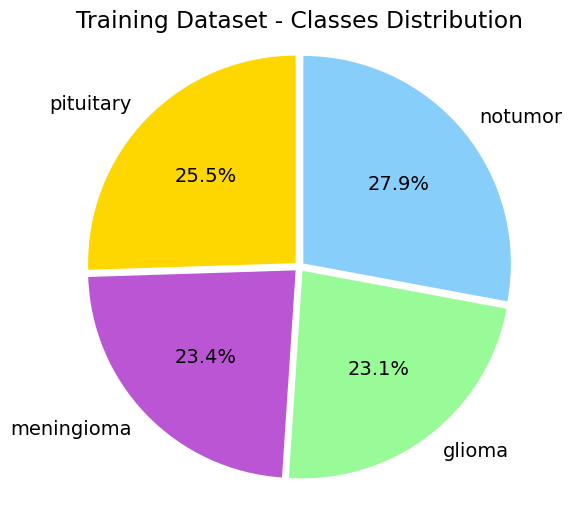

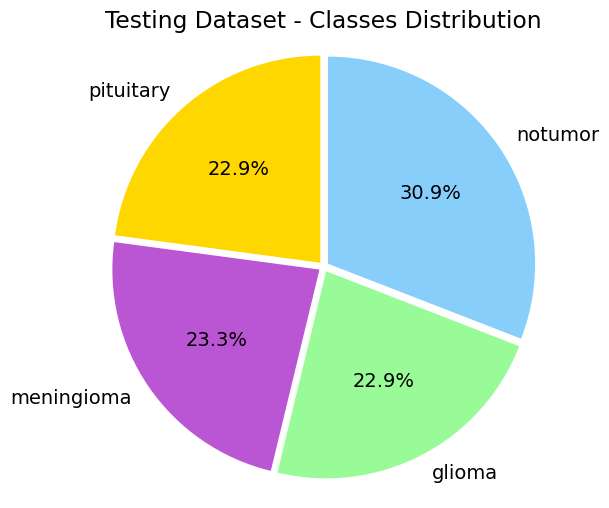

In [16]:
# Define custom colors for the pie chart

colors = ['gold', 'mediumorchid', 'palegreen', 'lightskyblue']

# Create a pie chart for the training dataset
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':14})
plt.pie(train_counts, labels=train_categories,colors=colors, autopct='%1.1f%%', explode=(0.025,0.025, 0.025,0.025),startangle=90)
plt.title('Training Dataset - Classes Distribution')
plt.axis('equal')
plt.show()

# Create a pie chart for the testing dataset
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':14})
plt.pie(test_counts, labels=test_categories,colors=colors, autopct='%1.1f%%', explode=(0.025,0.025, 0.025,0.025),startangle=90)
plt.title('Testing Dataset - Classes Distribution')
plt.axis('equal')
plt.show()


### The data is balanced.

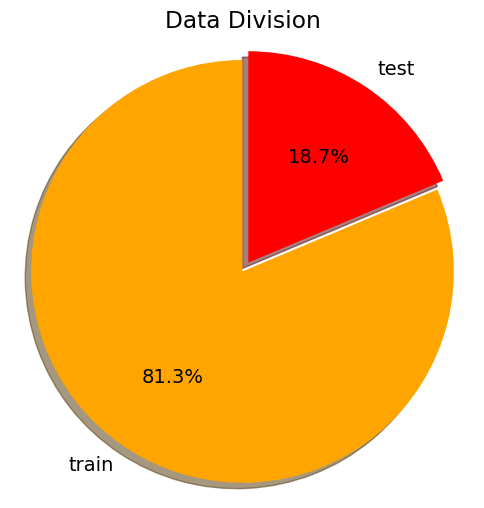

5712 1311


In [17]:
# That is the proportion of train and test

# The total number of pictures in train and test
train_size=sum(train_counts)
test_size= sum(test_counts)

colors = ['orange', 'red']

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 14})
plt.pie([train_size, test_size], labels=['train', 'test'], colors=colors, autopct='%1.1f%%', explode=(0.05, 0),
        startangle=90, shadow=True)
plt.title('Data Division')
plt.axis('equal')
plt.show()

print(train_size, test_size)

## Lets see some samples of the classes

### Example of Normal brain

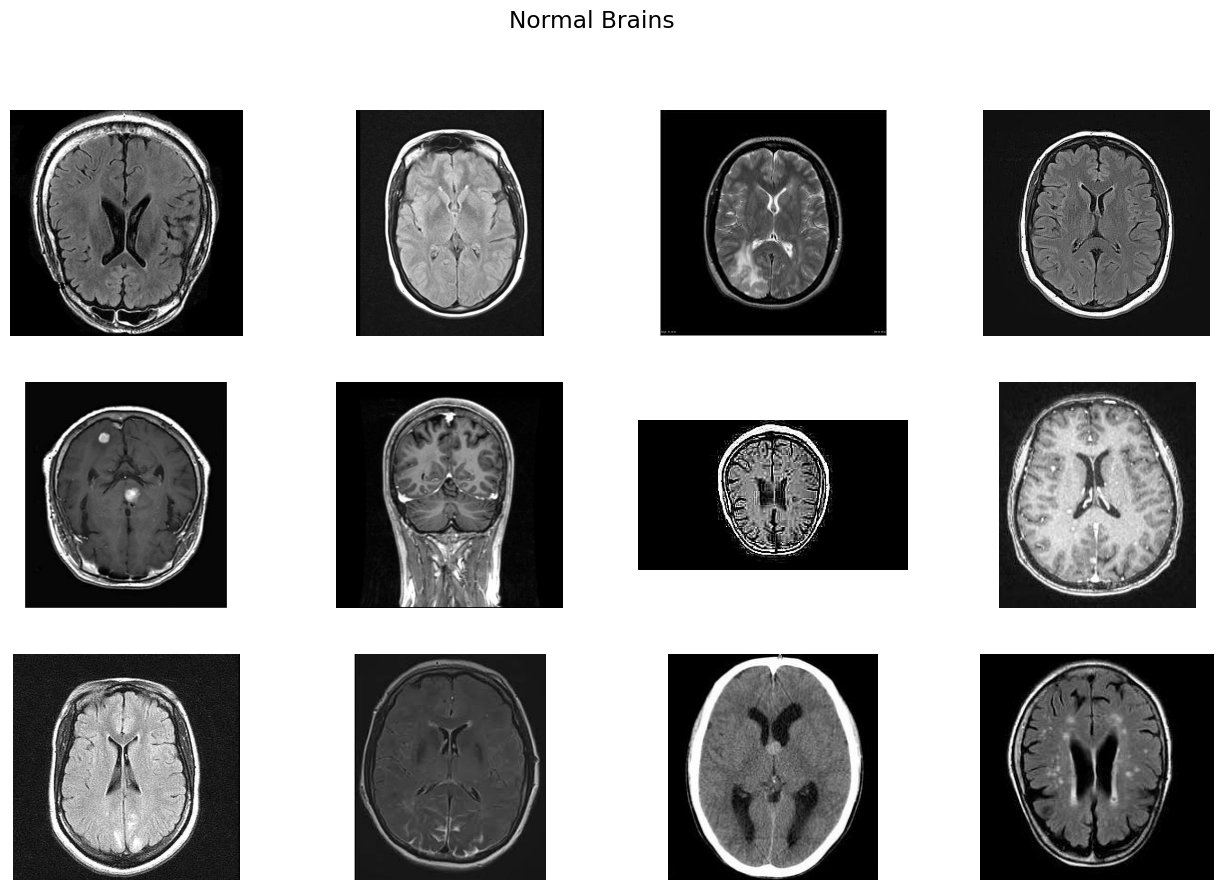

In [19]:
notumor_dir = 'Training/notumor'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(notumor_dir)

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Normal Brains')

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3,4, i + 1)
    img = cv2.imread(os.path.join(notumor_dir, filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()

### Glioma Tumor

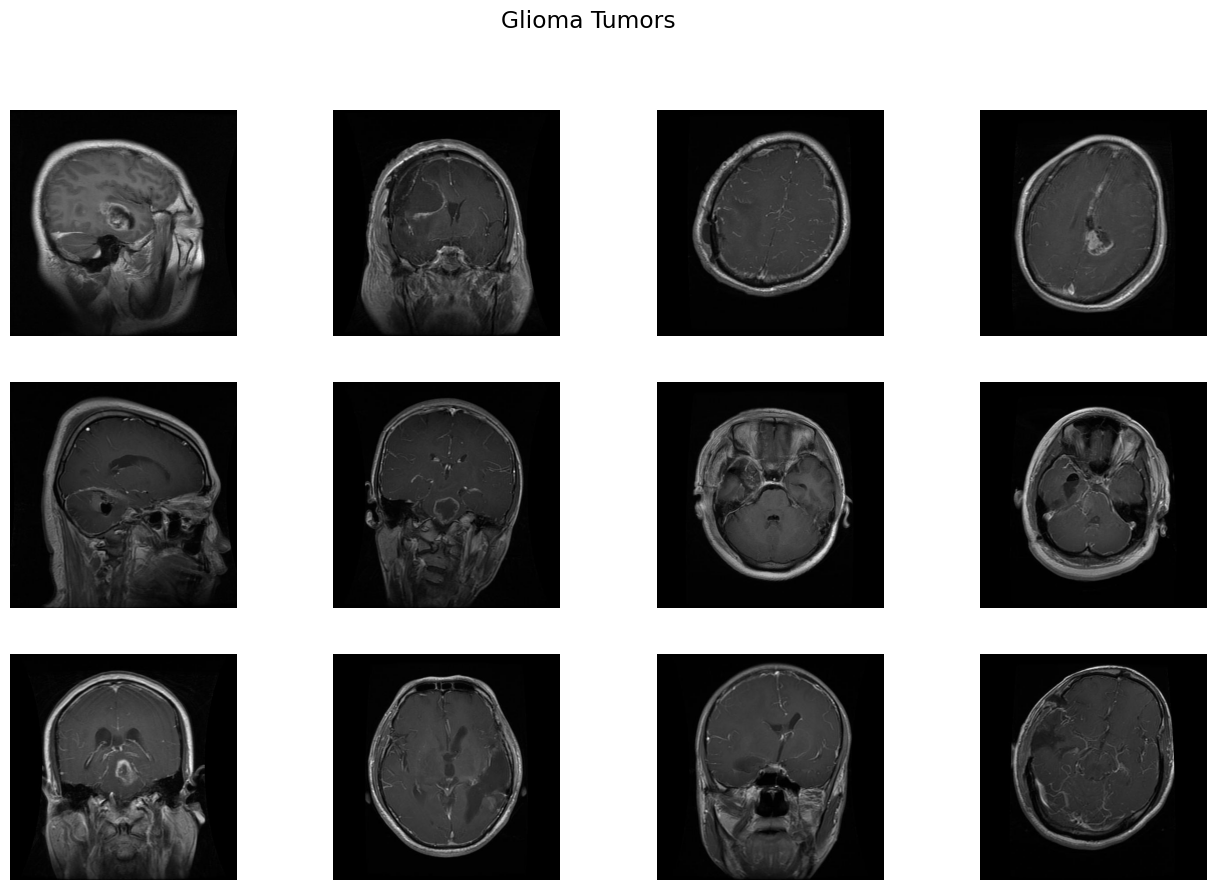

In [20]:
notumor_dir = 'Training/glioma'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(notumor_dir)

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Glioma Tumors')

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3,4, i + 1)
    img = cv2.imread(os.path.join(notumor_dir, filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()

### Meningioma Tumor

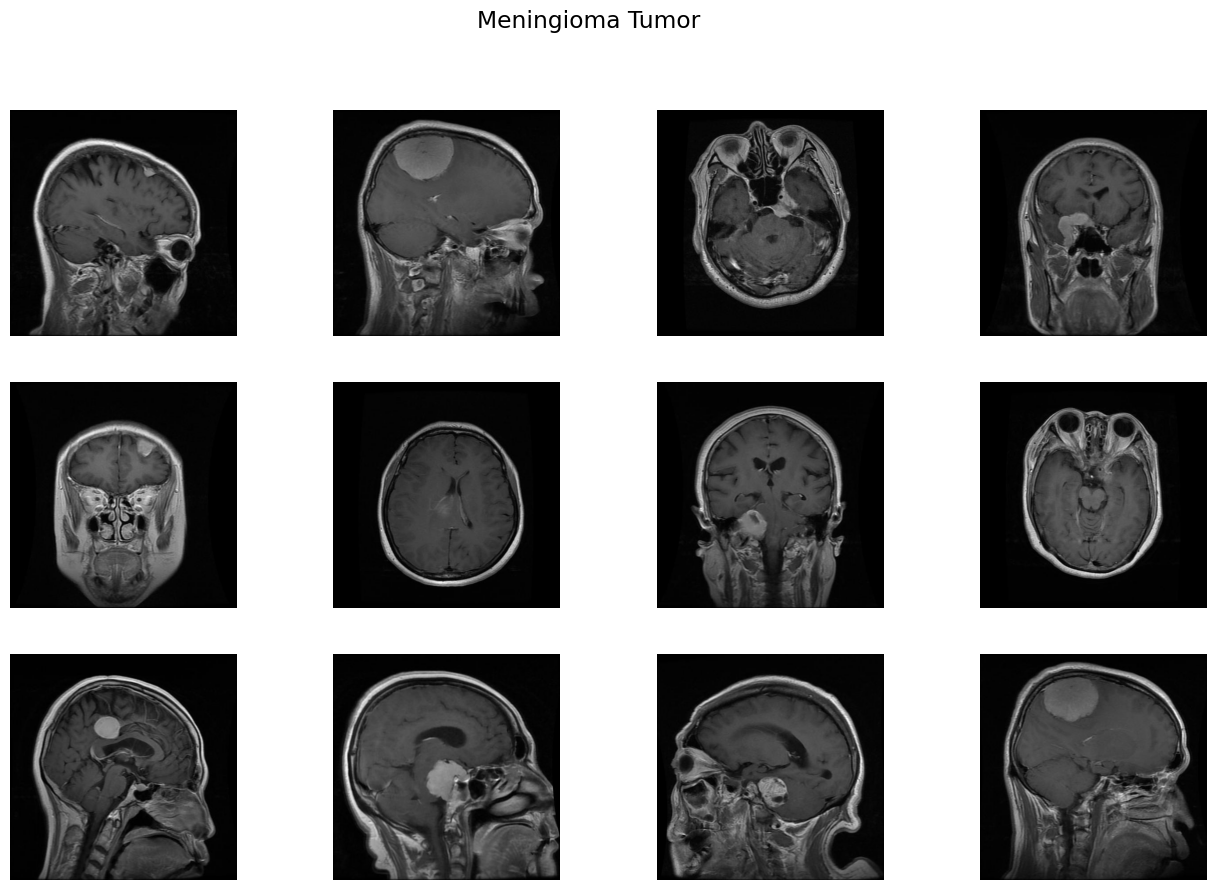

In [23]:
meningioma_dir = 'Training/meningioma'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(meningioma_dir )

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Meningioma Tumor')

x=10

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3, 4, i + 1)
    img = cv2.imread(os.path.join(meningioma_dir , filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()


### Pituitary Tumor

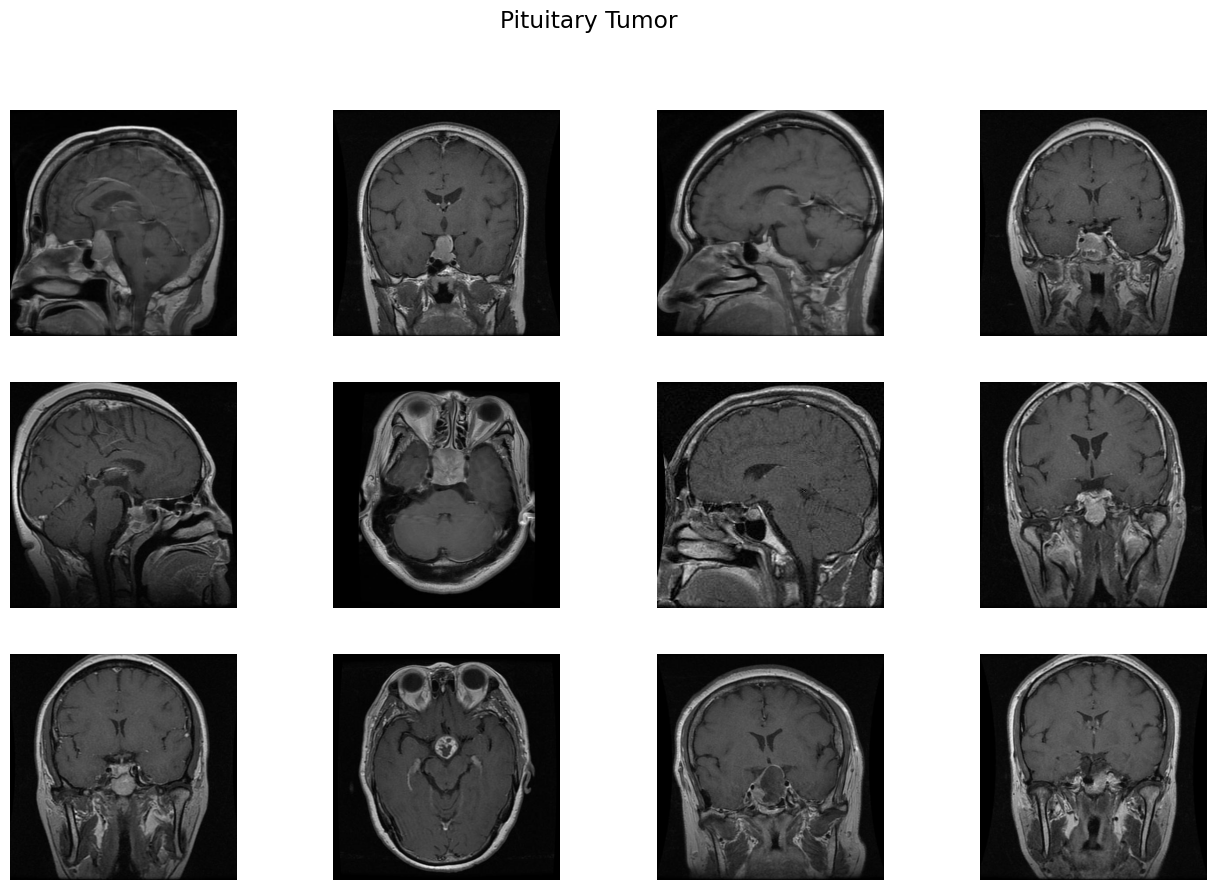

In [24]:
pituitary_dir = 'Training/pituitary'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(pituitary_dir )

# Randomly select 9 images
selected_images = random.sample(image_files, 12)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Pituitary Tumor')

x=10

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3, 4, i + 1)
    img = cv2.imread(os.path.join(pituitary_dir , filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()


In [26]:
#Image resize to 128 to 128
img_size = 128
image_array_train = cv2.resize(img_array_train, (img_size,img_size))
image_array_test = cv2.resize(img_array_test, (img_size,img_size))

In [ ]:
gt1 = cv2.imread(train_dir+'glioma/Tr-gl_0028.jpg')
mt1 = cv2.imread(train_dir+'meningioma/Tr-me_0030.jpg')
nt1 = cv2.imread(train_dir+'notumor/Tr-no_0035.jpg')
pt1 = cv2.imread(train_dir+'pituitary/Tr-pi_0038.jpg')

## Convert each image to grayscale and append into an array

In [27]:
#Conversion to gray scale image using cv2.IMREAD_GRAYSCALE argument and creation of train data
#Each element of list contains image vector representation in place 0 and classification label in place 1
train_data = []

for i in categories:
    train_path = os.path.join(train_dir,i)
    tag = categories.index(i)
    for img in os.listdir(train_path):
        try:
            image_arr = cv2.imread(os.path.join(train_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            train_data.append([new_image_array , tag])
        except Exception as e:
            pass

In [28]:
# convert to gray scale the test array
test_data = []

for i in categories:
    test_path = os.path.join(test_dir,i)
    tag = categories.index(i)
    for img in os.listdir(test_path):
        try:
            image_arr = cv2.imread(os.path.join(test_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            test_data.append([new_image_array , tag])
        except Exception as e:
            pass


## Split the features and target in to X and y

In [29]:
#Train data
X = []
y = []
for i,j in train_data:
    X.append(i)
    y.append(j)
X = np.array(X).reshape(-1,img_size,img_size)
print(X.shape)
#print(X[0])
X = X/255.0
#print(X[0])
X = X.reshape(-1,128,128,1)
print(X.shape)


(5712, 128, 128)
(5712, 128, 128, 1)


In [30]:
from keras.utils import to_categorical

y_train = to_categorical(y, num_classes = 4)

In [43]:
# Test data
X_test = []
y_test = []
for i,j in test_data:
    X_test.append(i)
    y_test.append(j)
X_test = np.array(X_test).reshape(-1,img_size,img_size)
print(X_test.shape)

X_test = X_test/255.0

X_test = X_test.reshape(-1,128,128,1)
print(X_test.shape)



(1311, 128, 128)
(1311, 128, 128, 1)


In [44]:
y_test = to_categorical(y_test, num_classes = 4)
print(np.array(y_test).shape)

(1311, 4)


### Split the data into Train, Validation  (80%-20%)

In [40]:

X_train , X_val, y_train, y_val = train_test_split(X , y , test_size = 0.2, random_state = 42)
num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# Check the shapes of the resulting arrays
print(X_train.shape)
print(X_val.shape)
print(np.array(y_train).shape)
print(np.array(y_val).shape)



(4569, 128, 128, 1)
(1143, 128, 128, 1)
(4569, 4)
(1143, 4)


## Import keras' functions to create CNN model

In [34]:
# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import itertools
import pydot
import graphviz

In [ ]:
!pip install pydot

In [ ]:
!pip install graphviz

In [56]:


model = Sequential()


model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (128,128,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(4, activation = "softmax"))

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 15

es = EarlyStopping(
    monitor='loss',
    mode='max',
    patience = 15
)

batch_size = 16
imggen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=True,
        vertical_flip=False)

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Fit the model with Train and Validation datatsets

In [57]:
history = model.fit(
    imggen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[es])

Epoch 1/15
285/285 [==============================] - 12s 28ms/step - loss: 0.8820 - accuracy: 0.6167 - val_loss: 0.6194 - val_accuracy: 0.7839
Epoch 2/15
285/285 [==============================] - 7s 25ms/step - loss: 0.5917 - accuracy: 0.7676 - val_loss: 0.4650 - val_accuracy: 0.8110
Epoch 3/15
285/285 [==============================] - 7s 25ms/step - loss: 0.4722 - accuracy: 0.8131 - val_loss: 0.4702 - val_accuracy: 0.8180
Epoch 4/15
285/285 [==============================] - 7s 26ms/step - loss: 0.4328 - accuracy: 0.8311 - val_loss: 0.4360 - val_accuracy: 0.8128
Epoch 5/15
285/285 [==============================] - 7s 26ms/step - loss: 0.3708 - accuracy: 0.8524 - val_loss: 0.3347 - val_accuracy: 0.8784
Epoch 6/15
285/285 [==============================] - 7s 24ms/step - loss: 0.3076 - accuracy: 0.8794 - val_loss: 0.2995 - val_accuracy: 0.8836
Epoch 7/15
285/285 [==============================] - 7s 26ms/step - loss: 0.2589 - accuracy: 0.9051 - val_loss: 0.2473 - val_accuracy: 0.914

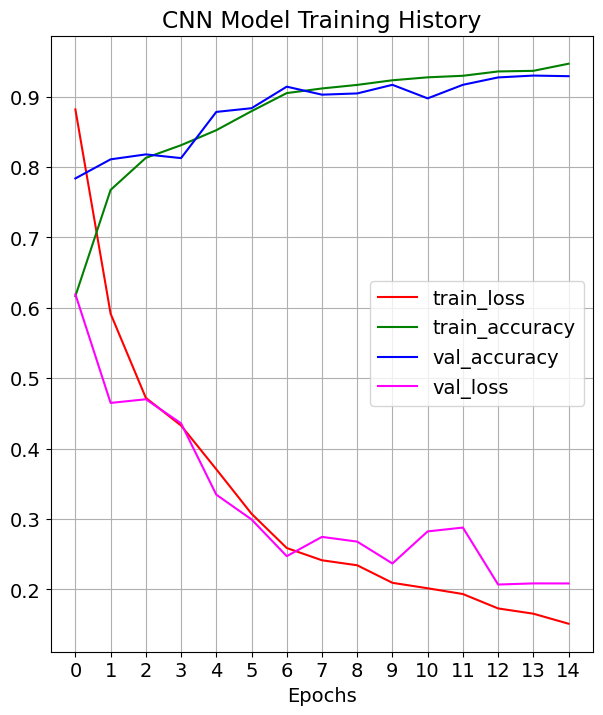

In [58]:
plt.plot(history.history["loss"],c = "red")
plt.plot(history.history["accuracy"],c = "green")
plt.plot(history.history['val_accuracy'], c = "blue")
plt.plot(history.history['val_loss'], c = "magenta")
plt.grid(True)
plt.title("CNN Model Training History")
plt.xlabel("Epochs")
plt.xticks([x for x in range(epochs)])
plt.legend(["train_loss", "train_accuracy",'val_accuracy','val_loss'])
plt.rcParams["figure.figsize"] = (7,8)
plt.show()

## Validation with test samples

In [59]:
score=model.evaluate(X_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy:',score[1])

Test loss 0.23505111038684845
Test accuracy: 0.9160946011543274


In [74]:
# Make predictions on the test data
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# If your y_test is one-hot encoded, you may need to convert it to class labels as well
y_true = np.argmax(y_test, axis=1)


# Generate the classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

41/41 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       300
           1       0.92      0.72      0.81       306
           2       0.90      0.99      0.95       405
           3       0.94      1.00      0.97       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.91      1311

